In [5]:
import os                                                                                # for working with files
import cv2                                                                               # for reading the images
import shap                                                                              # for checking feature importances
import torch                                                                             # Pytorch module 
import pickle
import shutil                                                                            # copying and moving files
import warnings                                                                          # ignoring warnings
import numpy as np                                                                       # for numerical computations
import pandas as pd                                                                      # for working with dataframes
from PIL import Image                                                                    # for checking images
import seaborn as sns
import torch.nn as nn                                                                    # for creating  neural networks
from pathlib import Path
import matplotlib.pyplot as plt                                                          # for plotting informations on graph and images using tensors
import torch.nn.functional as F                                                          # for functions for calculating loss
import sklearn.metrics as metrics                                                        # using the sklearn metrics
import torchvision.transforms as T                                                       # pytorch transformations
from torch.utils.data import DataLoader                                                  # for dataloaders 
from torchvision.utils import make_grid                                                  # for data checking
import torchvision.transforms as transforms                                              # for transforming images into tensors 
from torchvision.datasets import ImageFolder                                             # for working with classes and images
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
%matplotlib inline

In [6]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [7]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [8]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))
        

In [9]:
# Architecture for training
# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture 
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases), 
                                       nn.Softmax(dim=1))
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out        

--------------------------

In [10]:
PATH = '../input/models/resnet9-mdlsd.pth'

model = ResNet9(3, 3)
model.load_state_dict(torch.load(PATH))
model.eval()

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

-----------------------------------------------

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
model = to_device(model, device) 
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

### Testing and Evaluation

In [13]:
###Creating a new test dir because there was an svn file or folder found in the test dir
os.mkdir('../test_data')
os.mkdir('../test_data/test')

In [14]:
test_dir = '/kaggle/input/pt-leaf-data/idata/Image Dataset/test_data/'
os.listdir(test_dir)

['test']

In [15]:
test_dir_old = test_dir
test_dir_new = '../test_data'
print(test_dir_old)
print(test_dir_new)

/kaggle/input/pt-leaf-data/idata/Image Dataset/test_data/
../test_data


In [16]:
test_dir_old

'/kaggle/input/pt-leaf-data/idata/Image Dataset/test_data/'

In [17]:
# import os
for f in os.listdir(f'{test_dir_new}/test'):
    os.remove(f'{test_dir_new}/test/{f}')

In [18]:
os.listdir(f'{test_dir_new}/test')

[]

In [19]:
train_classes = ['early_blight', 'healthy', 'late_blight']
for theclass in train_classes:
    os.mkdir(f"{test_dir_new}/test/{theclass}")

In [20]:
os.listdir(f'{test_dir_new}/test')

['healthy', 'early_blight', 'late_blight']

In [21]:
os.listdir(f'{test_dir_new}/test')

['healthy', 'early_blight', 'late_blight']

In [22]:
###Moving file from old test dir to new test dir
num_moved = 0
for img in os.listdir(test_dir_old+'/test'):
    if img.endswith('.JPG'):
        if img.split('_')[1] !='healthy':
            theclass = img.split('_')[1] + '_blight'
            #print(theclass)
            shutil.copy(f"{test_dir_old+'/test/'}{img}", f"{test_dir_new+'/test/'+theclass+'/'+img}")
        
        elif img.split('_')[1] =='healthy':
            theclass = img.split('_')[1] 
            #print(theclass)
            shutil.copy(f"{test_dir_old+'/test/'}{img}", f"{test_dir_new+'/test/'+theclass+'/'+img}")
        
        num_moved += 1
    elif img.endswith('svn'):
        print('not going to move you!')
print(f"Number of files moved: {num_moved}")

not going to move you!
Number of files moved: 1331


In [23]:
len(os.listdir(f'{test_dir_new}/test')) #3 folders which are early_blight, healthy and late_blight

3

In [24]:
len(os.listdir('../test_data/test')) #files have been moved

3

In [25]:
os.listdir(f"{test_dir_new}")

['test']

In [26]:
#Testing model on test data
test = ImageFolder('../test_data/test', transform=transforms.Compose(
                                        [transforms.Resize([256, 256]),
                                         transforms.ToTensor()]))

In [27]:
test

Dataset ImageFolder
    Number of datapoints: 1331
    Root location: ../test_data/test
    StandardTransform
Transform: Compose(
               Resize(size=[256, 256], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [28]:
os.listdir(test_dir_new + '/test')

['healthy', 'early_blight', 'late_blight']

In [29]:
early = os.listdir(test_dir_new + '/test/healthy')
healthy = os.listdir(test_dir_new + '/test/early_blight')
late = os.listdir(test_dir_new + '/test/late_blight')

test_images = sorted(early+healthy+late) # since images in test folder are not in alphabetical order
print(len(test_images))

1331


In [30]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train_classes[preds[0].item()]

In [31]:
len(test)

1331

In [32]:
img, label = test[-1]
label

2

In [33]:
print(len(test_images))
print(len(test))

1331
1331


In [34]:
print(len(test_images))
print(len(test))

1331
1331


### ResNet-9 model evaluation on test data

Label: tomato_late_207.JPG , Predicted: late_blight


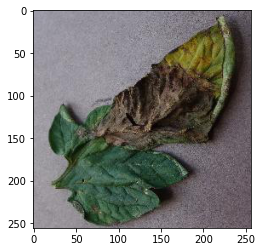

In [35]:
# predicting first image
img, label = test[1000]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[1000], ', Predicted:', predict_image(img, model))

In [36]:
batch_size = 32
test_loader_r = torch.utils.data.DataLoader(test, 
                                            batch_size=batch_size,
                                            shuffle=True)

test_loader_r = DeviceDataLoader(test_loader_r, device)
test_loader_r

In [47]:
predictions =[] #code adapted from https://stackoverflow.com/questions/63647547/how-to-find-confusion-matrix-and-plot-it-for-image-classifier-in-pytorch
targets = []
for images, labels in test_loader_r:
    images, labels = images.cuda(), labels.cuda()
    logps = model(images)
    output = torch.exp(logps)
    pred = torch.argmax(output, 1)

    # convert to numpy arrays
    pred = pred.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    
    for i in range(len(pred)):
        predictions.append(pred[i])
        targets.append(labels[i])

In [49]:
train_classes

['early_blight', 'healthy', 'late_blight']

In [50]:
targets[:5]

[0, 1, 2, 0, 1]

In [51]:
predictions[:5]

[0, 1, 2, 0, 1]

### Confusion matrix

In [52]:
cf_matrix = confusion_matrix(targets, predictions)
cf_matrix

array([[433,   0,   9],
       [  0, 250,   0],
       [  1,   0, 638]])

In [54]:
class_names = train_classes
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)
dataframe

,early_blight,healthy,late_blight
early_blight,433,0,9
healthy,0,250,0
late_blight,1,0,638


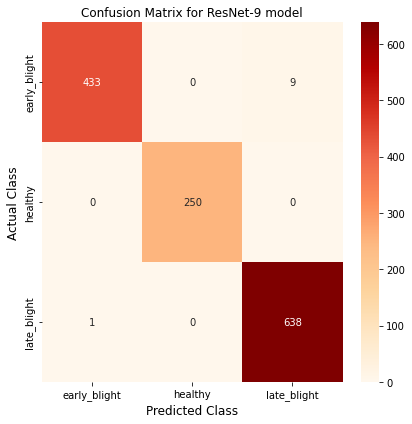

In [55]:
plt.figure(figsize=(6, 6))  #change size to 4, 4?

#Create heatmap
sns.heatmap(dataframe, annot=True, cbar=True,cmap="OrRd",fmt="d") #'purples', 'PuRd'
plt.title("Confusion Matrix for ResNet-9 model", size=12), plt.tight_layout()
 
plt.ylabel("Actual Class", size=12), 
plt.xlabel("Predicted Class",  size=12)
plt.tight_layout()
#plt.savefig('../working/cmatrxresnet9.png', dpi=600,  bbox_inches="tight")
plt.show()

### Test accuracy and classification report

In [57]:
print("Test Accuracy : {}".format(accuracy_score(targets, predictions)))
print("\nConfusion Matrix : ")
print(confusion_matrix(targets, predictions))
print("\nClassification Report :")
print(classification_report(targets, predictions, target_names=train_classes))

Test Accuracy : 0.9924868519909842

Confusion Matrix : 
[[433   0   9]
 [  0 250   0]
 [  1   0 638]]

Classification Report :
              precision    recall  f1-score   support

early_blight       1.00      0.98      0.99       442
     healthy       1.00      1.00      1.00       250
 late_blight       0.99      1.00      0.99       639

    accuracy                           0.99      1331
   macro avg       0.99      0.99      0.99      1331
weighted avg       0.99      0.99      0.99      1331



## Model Explanations (DeepShap and Saliency Maps)

# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

test_loader_r = torch.utils.data.DataLoader(test, 
                                            batch_size=batch_size,
                                            shuffle=True)

test_loader_r = DeviceDataLoader(test_loader_r, device)
test_loader_r

In [52]:
# since shuffle=True, this is a random sample of test data
images, targets =  next(iter(test_loader_r))
BACKGROUND_SIZE = 20
background_images = images[:BACKGROUND_SIZE]
background_targets = targets[:BACKGROUND_SIZE].cpu().numpy()
#increase the size after you've fixed everything 

test_images = images[BACKGROUND_SIZE:BACKGROUND_SIZE+9]
test_targets = targets[BACKGROUND_SIZE:BACKGROUND_SIZE+9].cpu().numpy()
def show_attributions(model):
    # predict the probabilities of the digits using the test images
    output = model(test_images.to(device))
    # get the index of the max log-probability
    pred = output.max(1, keepdim=True)[1] 
    # convert to numpy only once to save time
    pred_np = pred.cpu().numpy() 

    expl = shap.DeepExplainer(model, background_images)
    train_classes = ['early_blight', 'healthy', 'late_blight']
    for i in range(0, len(test_images)):
        warnings.filterwarnings('ignore')
        
        torch.cuda.empty_cache()
        ti = test_images[[i]]
        sv = expl.shap_values(ti)
        sn = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in sv]
        tn = np.swapaxes(np.swapaxes(ti.cpu().numpy(), 1, -1), 1, 2) #.cpu().numpy()?

        # Prepare the attribution plot, but do not draw it yet
        # We will add more info to the plots later in the code
        shap.image_plot(sn, -tn, show=False)

        # Prepare to augment the plot
        fig = plt.gcf()
        allaxes = fig.get_axes()

        allaxes[0].set_title('Actual: {}, Pred: {}'.format(train_classes[test_targets[i]], train_classes[pred_np[i][0]]), fontsize=10)
        #print(train_classes[test_targets[i]], '\n', pred_np[i][0])
        
        prob = output[i].detach().cpu().numpy()
        for x in range(1, len(allaxes)-1):
            #allaxes[x].set_title('{}'.format(train_classes[x-1]), fontsize=10)
            allaxes[x].set_title('{}({:.2%})'.format(train_classes[x-1], prob[x-1]), fontsize=10)
            allaxes[0].imshow(test_images[i].cpu().permute(1, 2, 0))       
            

        
        plt.savefig(f'sal_map_{i}.png')
        plt.show()

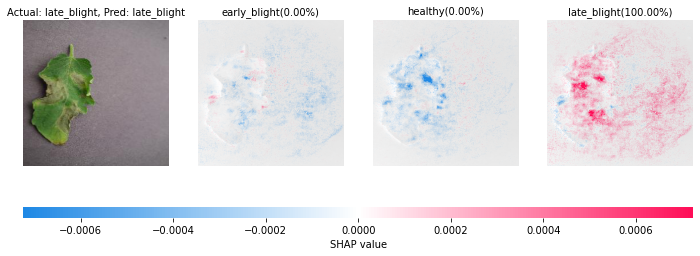

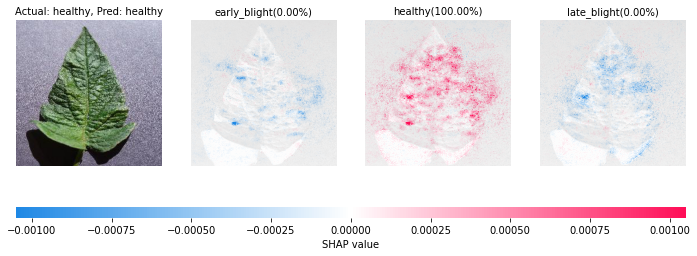

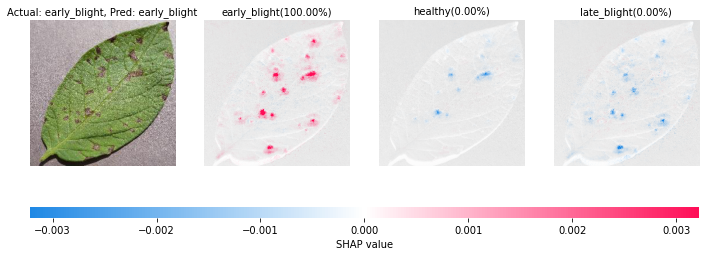

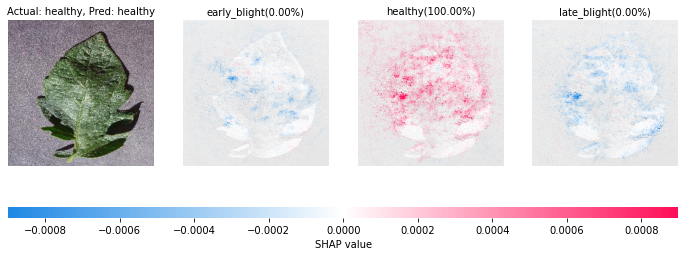

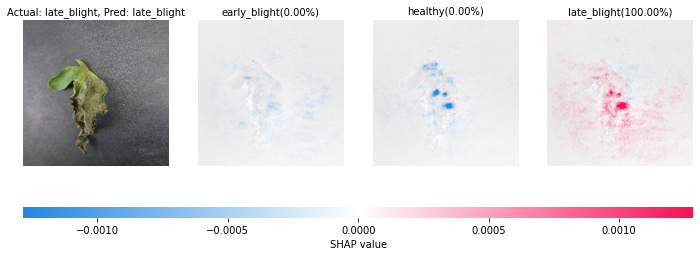

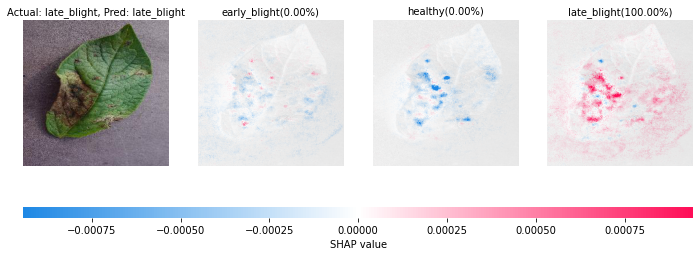

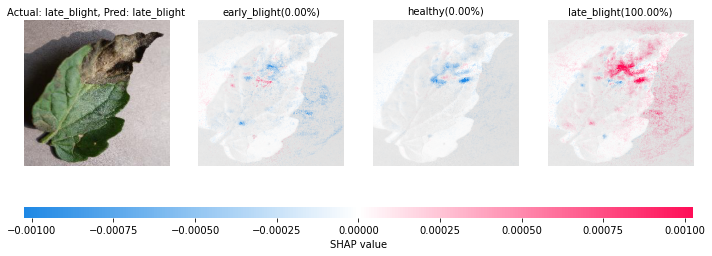

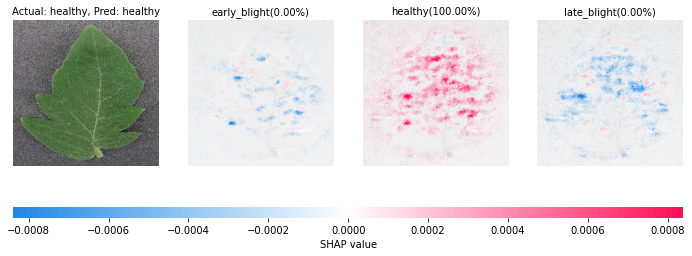

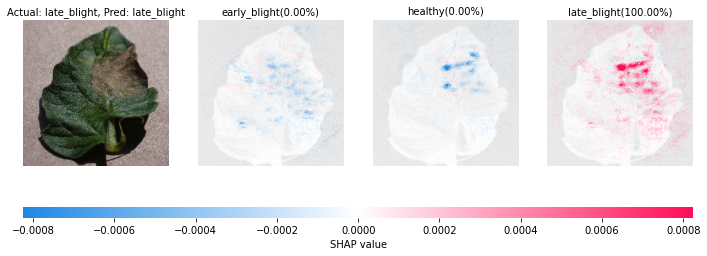

In [53]:
feature_attributions = show_attributions(model)
feature_attributions